In [39]:
import numpy as np
import os
import pathlib
import random
import torch
import pytorch3d.transforms
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [40]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [41]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

def getLinkInitialLength(linkName):
    linkObject = learnable_robot_model._get_parent_object_of_param(joint, "trans")
    return linkObject.trans().detach().clone()

def makeLinkLengthLearnable(linkName, value = None):
    linkObject = learnable_robot_model._get_parent_object_of_param(joint, "trans")
    learnable_robot_model.make_link_param_learnable(
        linkName, 
        "trans", 
        UnconstrainedTensor(dim1 = 1, dim2 = 3, init_tensor = value)
    )
    print(f"Made {linkName} link's length learnable initialized tensor to {value}")

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

intialJointAngles = {joint: getLinkInitialLength(joint) for joint in learnable_robot_model.get_link_names()}

for joint in intialJointAngles:
    makeLinkLengthLearnable(joint, initialJointAngles[joint])

Made base link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made trunk link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made imu_link link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made FR_hip link's length learnable initialized tensor to tensor([[ 0.181, -0.047,  0.000]])
Made FR_thigh_shoulder link's length learnable initialized tensor to tensor([[ 0.000, -0.081,  0.000]])
Made FR_thigh link's length learnable initialized tensor to tensor([[ 0.000, -0.084,  0.000]])
Made FR_calf link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FR_foot link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FL_hip link's length learnable initialized tensor to tensor([[0.181, 0.047, 0.000]])
Made FL_thigh_shoulder link's length learnable initialized tensor to tensor([[0.000, 0.081, 0.000]])
Made FL_thigh link's length learnable initialized tensor to tensor([[0.000, 0.084, 0.00

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [42]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")

image_robot_mapping = [
['FL_Ankle', "FL_foot"],
['FR_Ankle', "FR_foot"],
['FL_Knee', "FL_calf"],
['FR_Knee', "FR_calf"],
['BL_Ankle', "RR_foot"],
['BR_Ankle', "RL_foot"],
['BL_Knee', "RR_calf"], 
['BR_Knee', "RL_calf"], 
["Hip", "RR_hip"], 
["Hip", "RL_hip"], 
["Shoulder","FL_thigh_shoulder"],
["Shoulder","FR_thigh_shoulder"]
]
                       
training_keypoints = [imageToRobotPair[0] for imageToRobotPair in image_robot_mapping]
robot_joints_for_training = [imageToRobotPair[1] for imageToRobotPair in image_robot_mapping]
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
trainingDataDirectory = base_dir / "HorseInferenceFiles"

#Open video, if that fails stop the flow
video = cv2.VideoCapture(str(trainingDataDirectory/"trainset/trimmedHorseVideo.mp4"))
if not video.isOpened():
    assert False, "Video failed to open"

startingFrame = 100
numberOfFramesToTrainOn = 5

video.set(cv2.CAP_PROP_POS_FRAMES, startingFrame)

dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
poses = []
images = []
imgCount = numberOfFramesToTrainOn
for index in range(numberOfFramesToTrainOn):
    _,image = video.read()    
    images.append(image)
    if index == 0:
        pose = dlc_live.init_inference(image)
    else:
        pose = dlc_live.get_pose(image)
    pose = pose[indices_keypoints_training][:,0:2]
    pose = torch.from_numpy(pose).unsqueeze(0)
    poses.append(pose)
images = np.array(images)
video.release()
# X,Y coords of selected keypoints
training_data = torch.vstack(poses)
training_data.shape

torch.Size([5, 12, 2])

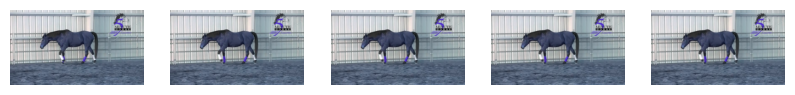

In [43]:
fig, axarr = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i in range(len(images)):
    axarr[i].imshow(images[i]) 
    axarr[i].axis('off') 
plt.show()

In [44]:
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

## Training Loop

Starting Training
Epoch 0: Loss (3745.557373046875), Loss Per Entry (70.43244934082031 pixels)
Epoch 0: Loss (3745.557373046875)


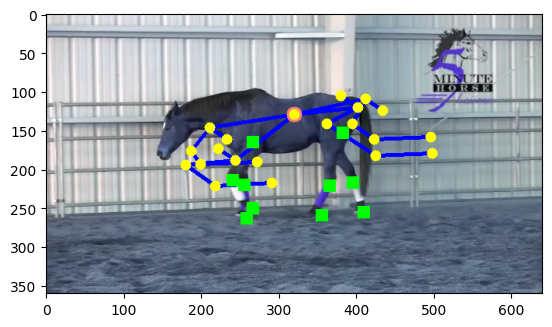

Epoch 10: Loss (3157.7626953125), Loss Per Entry (60.56422424316406 pixels)
Epoch 20: Loss (2798.194580078125), Loss Per Entry (54.53428268432617 pixels)
Epoch 30: Loss (2538.2646484375), Loss Per Entry (50.17259216308594 pixels)
Epoch 40: Loss (2306.491943359375), Loss Per Entry (46.29460525512695 pixels)
Epoch 50: Loss (2097.63330078125), Loss Per Entry (42.80668258666992 pixels)
Epoch 60: Loss (1915.4224853515625), Loss Per Entry (39.763431549072266 pixels)
Epoch 70: Loss (1823.2386474609375), Loss Per Entry (38.209983825683594 pixels)
Epoch 80: Loss (1771.8427734375), Loss Per Entry (37.30674743652344 pixels)
Epoch 90: Loss (1717.1605224609375), Loss Per Entry (36.348655700683594 pixels)
Epoch 100: Loss (1661.182861328125), Loss Per Entry (35.368019104003906 pixels)
Epoch 100: Loss (1661.182861328125)


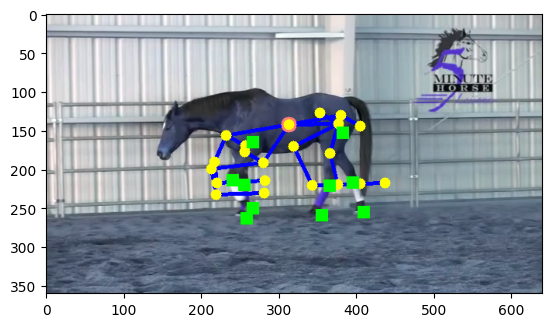

Epoch 110: Loss (1600.8817138671875), Loss Per Entry (34.31245040893555 pixels)
Epoch 120: Loss (1534.9847412109375), Loss Per Entry (33.16754150390625 pixels)
Epoch 130: Loss (1462.995849609375), Loss Per Entry (31.921146392822266 pixels)
Epoch 140: Loss (1385.1942138671875), Loss Per Entry (30.577608108520508 pixels)
Epoch 150: Loss (1300.9444580078125), Loss Per Entry (29.12999153137207 pixels)
Epoch 160: Loss (1215.2706298828125), Loss Per Entry (27.66179847717285 pixels)
Epoch 170: Loss (1136.112060546875), Loss Per Entry (26.312725067138672 pixels)
Epoch 180: Loss (1054.4866943359375), Loss Per Entry (24.93855857849121 pixels)
Epoch 190: Loss (986.175048828125), Loss Per Entry (23.793603897094727 pixels)
Epoch 200: Loss (918.81689453125), Loss Per Entry (22.679834365844727 pixels)
Epoch 200: Loss (918.81689453125)


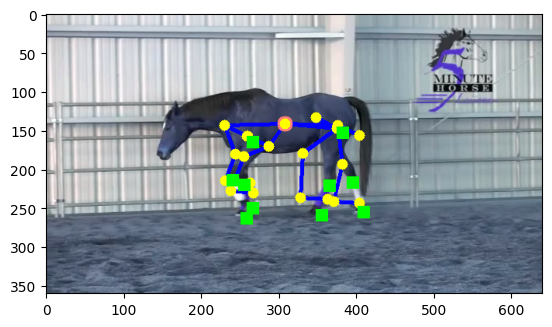

Epoch 210: Loss (861.5420532226562), Loss Per Entry (21.732707977294922 pixels)
Epoch 220: Loss (816.7534790039062), Loss Per Entry (20.966459274291992 pixels)
Epoch 230: Loss (779.0219116210938), Loss Per Entry (20.329029083251953 pixels)
Epoch 240: Loss (745.883544921875), Loss Per Entry (19.788082122802734 pixels)
Epoch 250: Loss (716.6104736328125), Loss Per Entry (19.311161041259766 pixels)
Epoch 260: Loss (691.55517578125), Loss Per Entry (18.898609161376953 pixels)
Epoch 270: Loss (664.166748046875), Loss Per Entry (18.44771385192871 pixels)
Epoch 280: Loss (640.3324584960938), Loss Per Entry (18.062320709228516 pixels)
Epoch 290: Loss (617.0807495117188), Loss Per Entry (17.68543243408203 pixels)
Epoch 300: Loss (596.5574951171875), Loss Per Entry (17.350482940673828 pixels)
Epoch 300: Loss (596.5574951171875)


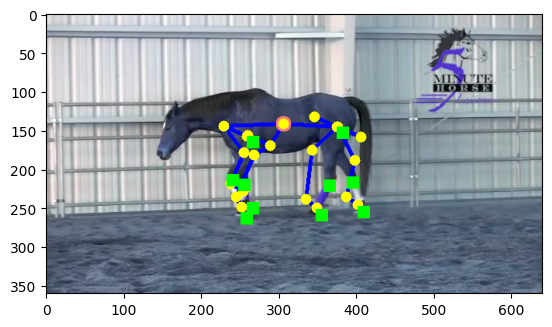

Epoch 310: Loss (574.3504638671875), Loss Per Entry (16.97861671447754 pixels)
Epoch 320: Loss (552.1699829101562), Loss Per Entry (16.612836837768555 pixels)
Epoch 330: Loss (531.3551025390625), Loss Per Entry (16.275060653686523 pixels)
Epoch 340: Loss (510.3233337402344), Loss Per Entry (15.932516098022461 pixels)
Epoch 350: Loss (490.50640869140625), Loss Per Entry (15.60446548461914 pixels)
Epoch 360: Loss (471.24725341796875), Loss Per Entry (15.288850784301758 pixels)
Epoch 370: Loss (452.61358642578125), Loss Per Entry (14.983976364135742 pixels)
Epoch 380: Loss (433.5903625488281), Loss Per Entry (14.675811767578125 pixels)
Epoch 390: Loss (415.2933349609375), Loss Per Entry (14.382290840148926 pixels)
Epoch 400: Loss (398.9952087402344), Loss Per Entry (14.122611045837402 pixels)
Epoch 400: Loss (398.9952087402344)


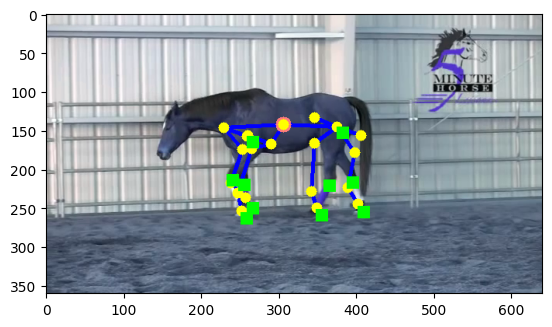

Epoch 410: Loss (382.72149658203125), Loss Per Entry (13.863235473632812 pixels)
Epoch 420: Loss (367.3547668457031), Loss Per Entry (13.619626998901367 pixels)
Epoch 430: Loss (351.36602783203125), Loss Per Entry (13.362406730651855 pixels)
Epoch 440: Loss (336.9734802246094), Loss Per Entry (13.132609367370605 pixels)
Epoch 450: Loss (323.85797119140625), Loss Per Entry (12.92557144165039 pixels)
Epoch 460: Loss (309.7140197753906), Loss Per Entry (12.703108787536621 pixels)
Epoch 470: Loss (297.1136474609375), Loss Per Entry (12.50639820098877 pixels)
Epoch 480: Loss (285.15692138671875), Loss Per Entry (12.319415092468262 pixels)
Epoch 490: Loss (274.51544189453125), Loss Per Entry (12.15511703491211 pixels)
Epoch 500: Loss (263.3003234863281), Loss Per Entry (11.979787826538086 pixels)
Epoch 500: Loss (263.3003234863281)


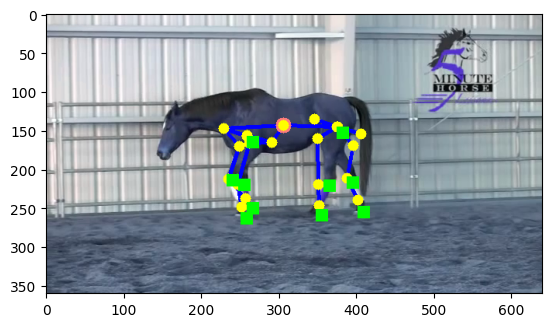

Epoch 510: Loss (252.78448486328125), Loss Per Entry (11.816158294677734 pixels)
Epoch 520: Loss (243.01785278320312), Loss Per Entry (11.665864944458008 pixels)
Epoch 530: Loss (235.06033325195312), Loss Per Entry (11.54726791381836 pixels)
Epoch 540: Loss (226.28012084960938), Loss Per Entry (11.419816017150879 pixels)
Epoch 550: Loss (220.2773895263672), Loss Per Entry (11.337202072143555 pixels)
Epoch 560: Loss (212.7969207763672), Loss Per Entry (11.237164497375488 pixels)
Epoch 570: Loss (205.7434539794922), Loss Per Entry (11.139938354492188 pixels)
Epoch 580: Loss (199.2229461669922), Loss Per Entry (11.05051326751709 pixels)
Epoch 590: Loss (194.09169006347656), Loss Per Entry (10.986621856689453 pixels)
Epoch 600: Loss (188.8865966796875), Loss Per Entry (10.922053337097168 pixels)
Epoch 600: Loss (188.8865966796875)


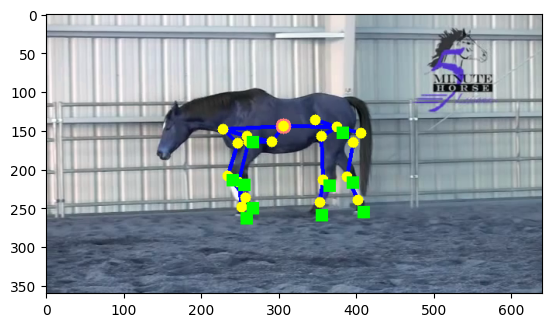

Epoch 610: Loss (185.8704376220703), Loss Per Entry (10.892557144165039 pixels)
Epoch 620: Loss (179.390869140625), Loss Per Entry (10.805505752563477 pixels)
Epoch 630: Loss (177.66221618652344), Loss Per Entry (10.796774864196777 pixels)
Epoch 640: Loss (172.89642333984375), Loss Per Entry (10.742033958435059 pixels)
Epoch 650: Loss (172.5238800048828), Loss Per Entry (10.759820938110352 pixels)
Epoch 660: Loss (167.85394287109375), Loss Per Entry (10.704743385314941 pixels)
Epoch 670: Loss (165.31796264648438), Loss Per Entry (10.682317733764648 pixels)
Epoch 680: Loss (160.1844940185547), Loss Per Entry (10.614760398864746 pixels)
Epoch 690: Loss (157.66522216796875), Loss Per Entry (10.588485717773438 pixels)
Epoch 700: Loss (157.47341918945312), Loss Per Entry (10.606674194335938 pixels)
Epoch 700: Loss (157.47341918945312)


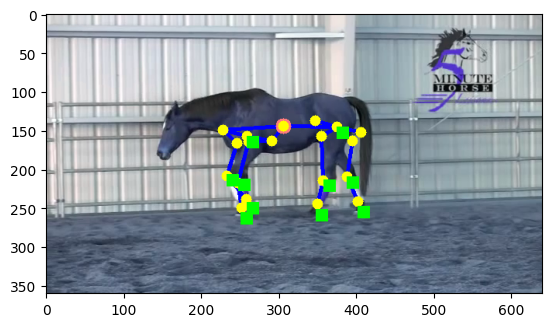

Epoch 710: Loss (153.6636199951172), Loss Per Entry (10.561178207397461 pixels)
Epoch 720: Loss (151.51309204101562), Loss Per Entry (10.540633201599121 pixels)
Epoch 730: Loss (150.0970916748047), Loss Per Entry (10.532397270202637 pixels)
Epoch 740: Loss (148.5005645751953), Loss Per Entry (10.520833969116211 pixels)
Epoch 750: Loss (146.78826904296875), Loss Per Entry (10.507406234741211 pixels)
Epoch 760: Loss (144.45408630371094), Loss Per Entry (10.481904029846191 pixels)
Epoch 770: Loss (143.501220703125), Loss Per Entry (10.478885650634766 pixels)
Epoch 780: Loss (141.33935546875), Loss Per Entry (10.456178665161133 pixels)
Epoch 790: Loss (139.8819122314453), Loss Per Entry (10.442399978637695 pixels)
Epoch 800: Loss (138.2193603515625), Loss Per Entry (10.42653751373291 pixels)
Epoch 800: Loss (138.2193603515625)


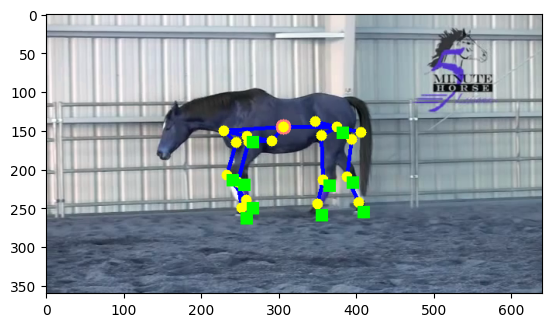

Epoch 810: Loss (138.18106079101562), Loss Per Entry (10.439249992370605 pixels)
Epoch 820: Loss (138.27581787109375), Loss Per Entry (10.455610275268555 pixels)
Epoch 830: Loss (136.8490447998047), Loss Per Entry (10.446050643920898 pixels)
Epoch 840: Loss (134.43264770507812), Loss Per Entry (10.41827392578125 pixels)
Epoch 850: Loss (135.38856506347656), Loss Per Entry (10.445220947265625 pixels)
Epoch 860: Loss (133.51153564453125), Loss Per Entry (10.426071166992188 pixels)
Epoch 870: Loss (134.39303588867188), Loss Per Entry (10.450881004333496 pixels)
Epoch 880: Loss (131.39686584472656), Loss Per Entry (10.41153621673584 pixels)
Epoch 890: Loss (130.01327514648438), Loss Per Entry (10.397317886352539 pixels)
Epoch 900: Loss (130.91036987304688), Loss Per Entry (10.422061920166016 pixels)
Epoch 900: Loss (130.91036987304688)


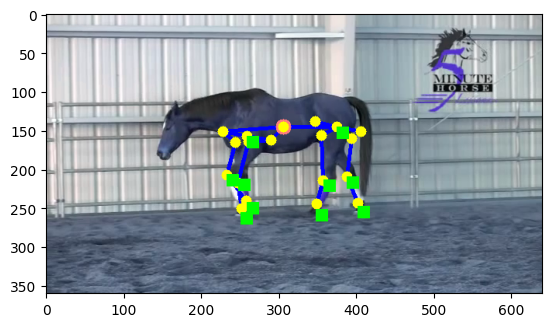

Epoch 910: Loss (129.28982543945312), Loss Per Entry (10.403867721557617 pixels)
Epoch 920: Loss (127.67367553710938), Loss Per Entry (10.384588241577148 pixels)
Epoch 930: Loss (127.59976196289062), Loss Per Entry (10.391276359558105 pixels)
Epoch 940: Loss (128.70046997070312), Loss Per Entry (10.415976524353027 pixels)
Epoch 950: Loss (129.19625854492188), Loss Per Entry (10.433798789978027 pixels)
Epoch 960: Loss (127.19756317138672), Loss Per Entry (10.40988826751709 pixels)
Epoch 970: Loss (126.95940399169922), Loss Per Entry (10.414484024047852 pixels)
Epoch 980: Loss (125.84066772460938), Loss Per Entry (10.403210639953613 pixels)
Epoch 990: Loss (125.14066314697266), Loss Per Entry (10.39761734008789 pixels)
Epoch 1000: Loss (124.88737487792969), Loss Per Entry (10.398133277893066 pixels)
Epoch 1000: Loss (124.88737487792969)


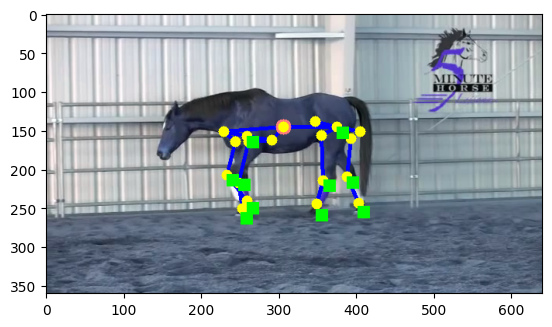

Epoch 1010: Loss (125.615966796875), Loss Per Entry (10.416646003723145 pixels)
Epoch 1020: Loss (124.86066436767578), Loss Per Entry (10.411219596862793 pixels)
Epoch 1030: Loss (123.46599578857422), Loss Per Entry (10.394230842590332 pixels)
Epoch 1040: Loss (124.35200500488281), Loss Per Entry (10.415597915649414 pixels)
Epoch 1050: Loss (124.88836669921875), Loss Per Entry (10.430536270141602 pixels)
Epoch 1060: Loss (123.62857055664062), Loss Per Entry (10.415754318237305 pixels)
Epoch 1070: Loss (122.33683776855469), Loss Per Entry (10.399585723876953 pixels)
Epoch 1080: Loss (122.4302978515625), Loss Per Entry (10.405939102172852 pixels)
Epoch 1090: Loss (121.14543151855469), Loss Per Entry (10.388910293579102 pixels)
Epoch 1100: Loss (121.15629577636719), Loss Per Entry (10.393016815185547 pixels)
Epoch 1100: Loss (121.15629577636719)


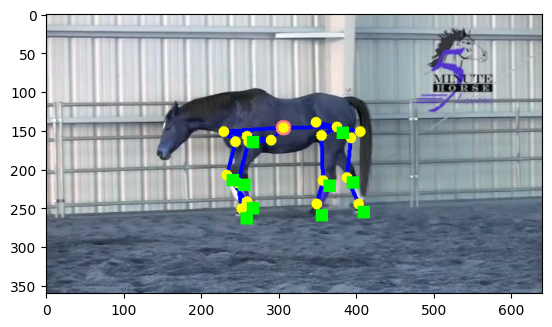

Epoch 1110: Loss (121.95873260498047), Loss Per Entry (10.41098403930664 pixels)


KeyboardInterrupt: 

In [50]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]


init_angles = torch.ones((12,))
init_angles = init_angles.repeat(imgCount,1)
joint_angles = init_angles.requires_grad_(True)

constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)

fx = differentiableConstantTensor(-320)
fy  = differentiableConstantTensor(130)
u0 = differentiableConstantTensor(320)
v0 = differentiableConstantTensor(130)



tx = torch.ones((imgCount,))*0
tx = tx.requires_grad_(True)
ty = torch.ones((imgCount,))*0
ty = ty.requires_grad_(True)
tz = torch.ones((imgCount,))*1
tz = tz.requires_grad_(True)

#Zero rotation quaternion
#Good visualization resource: https://quaternions.online
extrinsicRotationQuaternion = torch.tensor([1.0, 0.0,  0.0, 0.0])
extrinsicRotationQuaternion = extrinsicRotationQuaternion.unsqueeze(0) * torch.ones((imgCount,4))
extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)

%matplotlib inline
VERBOSE = True
optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3)
#optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
robotEEPositions = None
trainingFrames = []
for epoch in range(2*1000):
    optimizer.zero_grad()
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] == imgCount:
            continue
        robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_for_training])
    def calculateCameraProjection(intrinsic, extrinsic, jointPositions):
        transform = intrinsic@extrinsic
        pixelPositions = transform@(homogenize_vectors(jointPositions).transpose(1,2))
        pixelPositions = pixelPositions.transpose(1,2)
        pixelPositions = dehomogenize_vector(pixelPositions)
        return pixelPositions
    jointCameraPositions = calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data).reshape(-1,2)), 2),-1)))

    def interframeJointLoss(jointAngles):
        """
            The L2 norm computed for every joint. Measures frame by frame the changes in joint angles, to minimze it
        """
        return torch.sum(torch.sqrt(torch.sum(torch.pow(jointAngles[1:] - jointAngles[:-1],2), -1)))
    #Experimentally Ive seen it ranges it has a magnitude in the e-1's
    jointLoss = interframeJointLoss(joint_angles)

    def totalLimbLength():
        """
            Returns the length of all of the links of the robot
        """
        robotLinks = torch.vstack([learnable_robot_model._get_parent_object_of_param(joint, "trans").trans().detach().clone() for joint in learnable_robot_model.get_link_names()])
        return torch.sum(torch.sqrt(torch.sum(torch.pow(robotLinks,2),-1)))
    limbLengthLoss = totalLimbLength()

    loss = pixelLoss + 10*limbLengthLoss # + 

    n = 10
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss})")
        img = (images[0]).copy()
        positionByJoint = torch.cat([v[0].unsqueeze(0) if len(v.shape) >= 2 else v.unsqueeze(0) for v in robotEEPositions.values()])
        #
        allJointPosiitons = calculateCameraProjection(intrinsic, extrinsic, positionByJoint.unsqueeze(0).repeat(imgCount,1,1))[0]
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//4)
        #Draw Robot Joints
        for joint in jointToCameraPosition:
            jointPositionTensor = jointToCameraPosition[joint]
            color = (255,255,0)
            dotSize = size//2
            if joint == "base":
                color = (255,124,124)
                dotSize = int(dotSize*1.5)
            jointPosition = jointPositionTensor.clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),dotSize,color,-1)
        #Draw Keypoints
        for x,y in training_data[0]:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        trainingFrames.append(img)
        plt.clf()
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()